# Characteristics of Businesses - Group Exercise

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

tech_variables = 'https://api.census.gov/data/2018/abstcb/variables.html'
owner_variables = 'https://api.census.gov/data/2018/abscbo/variables.html'
characteristics_variables = 'https://api.census.gov/data/2018/abscb/variables.html'
company_summary_variables = 'https://api.census.gov/data/2018/abscs/variables.html'


### Get Tables of Variables

In [2]:
tech_vars = pd.read_html(tech_variables)[0]
owner_vars = pd.read_html(owner_variables)[0]
characteristic_vars = pd.read_html(characteristics_variables)[0]
company_summary_vars = pd.read_html(company_summary_variables)[0]

tech_vars = tech_vars[[_ for _ in tech_vars.columns[:2]]]
owner_vars = owner_vars[[_ for _ in owner_vars.columns[:2]]]
characteristic_vars = characteristic_vars[[_ for _ in characteristic_vars.columns[:2]]]
company_summary_vars = company_summary_vars[[_ for _ in company_summary_vars.columns[:2]]] 

tech_vars.rename(columns = {'Label': 'Tech Labels'}, inplace = True)
owner_vars.rename(columns = {'Label': 'Owner Labels'}, inplace = True)
characteristic_vars.rename(columns = {'Label': 'Characteristic Labels'}, inplace = True)
company_summary_vars.rename(columns = {'Label': 'Company Summary Labels'}, inplace = True)

In [3]:
grouped_tables = pd.merge(tech_vars, owner_vars, left_on = 'Name', right_on = 'Name', how = 'outer')
grouped_tables = pd.merge(grouped_tables, characteristic_vars, left_on = 'Name', right_on = 'Name', how = 'outer')
grouped_tables = pd.merge(grouped_tables, company_summary_vars , left_on = 'Name', right_on = 'Name', how = 'outer')
grouped_tables.fillna("-", inplace = True)
grouped_tables = grouped_tables[(~grouped_tables['Tech Labels'].str.contains('Standard error|standard error'))]
grouped_tables = grouped_tables[(~grouped_tables['Owner Labels'].str.contains('Standard error|standard error'))]
grouped_tables = grouped_tables[(~grouped_tables['Characteristic Labels'].str.contains('Standard error|standard error'))]
grouped_tables = grouped_tables[(~grouped_tables['Company Summary Labels'].str.contains('Standard error|standard error'))]

grouped_tables.reset_index(drop = True, inplace = True)
grouped_tables = grouped_tables[:-2]

In [4]:
# grouped_tables.sort_values(by = 'Name', ascending = False)
vars_of_interest = [
    'NAICS2017',
    'YIBSZFI',
    'SEX',
    'QDESC',
    'NSFSZFI',
    'GEO_ID',
    'RACE_GROUP',
    'BUSCHAR',
    'OWNER_RACE',
    'OWNER_SEX']
target_subset = grouped_tables[(grouped_tables['Name'].isin(vars_of_interest))]
target_subset = target_subset[['Name','Company Summary Labels','Characteristic Labels','Owner Labels','Tech Labels']]

### Build variable strings to pass to api call


In [5]:
variable_dict = {}
for i,label in enumerate(target_subset.columns[1:]):
    variable_list = []
    for item in target_subset[(target_subset[label] != "-")].Name.tolist():
        variable_list.append(item)
        variable_list.append(f'{item}_LABEL')
    variable_list = [_ for _ in variable_list if _ not in ['GEO_ID_LABEL']]#, 'QDESC_LABEL']]
    in_table = "NAME," + ",".join(variable_list)
    variable_dict[i] = in_table

In [6]:
industry_code = '61'
qdesc1 = 'B27'
links = [
    f'https://api.census.gov/data/2018/abscs?get={variable_dict[0]},FIRMPDEMP&for=us:*', #I CHANGED THIS from for=state:*
    f'https://api.census.gov/data/2018/abscb?get={variable_dict[1]},FIRMPDEMP&for=state:*',
    f'https://api.census.gov/data/2018/abscbo?get={variable_dict[2]},OWNCHAR,OWNCHAR_LABEL&for=us:*&for=QDESC_LABEL=YRACQBUS',
    f'https://api.census.gov/data/2018/abstcb?get={variable_dict[3]},FIRMPDEMP,TECHUSE&for=state:*',
]

def get_data_frame(url):
    return pd.read_csv(url)
    
for link in links:
    print(link)
    print("")

https://api.census.gov/data/2018/abscs?get=NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,YIBSZFI,YIBSZFI_LABEL,FIRMPDEMP&for=us:*

https://api.census.gov/data/2018/abscb?get=NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,QDESC,QDESC_LABEL,BUSCHAR,BUSCHAR_LABEL,YIBSZFI,YIBSZFI_LABEL,FIRMPDEMP&for=state:*

https://api.census.gov/data/2018/abscbo?get=NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,OWNER_RACE,OWNER_RACE_LABEL,OWNER_SEX,OWNER_SEX_LABEL,QDESC,QDESC_LABEL,OWNCHAR,OWNCHAR_LABEL&for=us:*&for=QDESC_LABEL=YRACQBUS

https://api.census.gov/data/2018/abstcb?get=NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,NSFSZFI,NSFSZFI_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,FIRMPDEMP,TECHUSE&for=state:*



### The cell below is where the dataframes are first stored.

In [7]:
comp_sum_df = get_data_frame(links[0]) # Company Summary
bus_char_df = business_char_df = get_data_frame(links[1]) # Business Characteristics
bus_own_df = business_own_df = get_data_frame(links[2]) # Business Owners
bus_tech_df = get_data_frame(links[3]) # Business Tech   

In [8]:
df_collection = [comp_sum_df, bus_char_df, bus_own_df, bus_tech_df]    
df_names = ['comp_sum_df', 'bus_char_df', 'bus_own_df', 'bus_tech_df']   

### Clean DataFrames

In [9]:
drop_list = [
    'race_group','sex','yibszfi','qdesc','buschar',
    'owner_race','owner_sex','us','ownchar'
]

for df in df_collection:
    column_names = [_ for _ in df.columns.tolist()]
    new_column_names = [_.replace("[[","").replace('"',"").replace("]","").lower() for _ in column_names]

    df.columns = new_column_names
    df.drop(columns = [_ for _ in new_column_names if ('unnamed' in _ or _ in drop_list)],inplace = True)
    df['name'] = df['name'].apply(lambda x: x.replace("[","").replace('"',""))
    
    if 'sex_label' in df.columns:
        df.rename(columns = {'sex_label': 'gender'}, inplace = True)
    
    if 'owner_sex_label' in df.columns:
        df.rename(columns = {'owner_sex_label': 'gender'}, inplace = True)
    
    if 'naics2017_label' in df.columns:
        df.rename(columns = {'naics2017_label': 'industry'}, inplace = True)
        
    if 'naics2017' in df.columns:
        df.rename(columns = {'naics2017': 'industry_code'}, inplace = True)

### Display some info about dataframes.

In [10]:
#for i,df in enumerate(df_collection):
#    print('\n############# NEW DATAFRAME ################')
#    print('Displaying column value counts where there are fewer than 10 unique values in the column.')
#    print(f'\n---  DataFrame: {df_names[i]} ---------------------')
#    print(f'Columns: {", ".join(df.columns.tolist())}')
#    for column in df:
#        if len(df[column].unique().tolist()) < 10:
#            print(df[column].value_counts())
#            print("")
#    print('############# END OF DATAFRAME INFO ################\n')

In [11]:
comp_sum_df[['industry_code','industry']].drop_duplicates();

In [12]:
gender_by_state_cs = comp_sum_df[
    (comp_sum_df['industry_code'].isin(['54','52']))
    ].groupby(by = ['name','industry','gender']
             )[['gender']].agg('count').rename(columns = {'gender': 'gender_count'}).reset_index()

gender_by_state_cs.sort_values(by = ['name', 'industry', 'gender'], inplace = True)
gs = gender_by_state_cs


In [13]:
print(len(comp_sum_df.name.unique())/3)

0.3333333333333333


In [14]:
#Cleaning for first visual
workingDF = df_collection[0]
workingDF = workingDF[workingDF['firmpdemp'] != 0]
workingDF = workingDF[workingDF['yibszfi_label'] == 'All firms']
workingDF = workingDF[workingDF['race_group_label'] == 'Total']

workingDF = workingDF[workingDF['industry'] != 'Industries not classified']

workingDF.drop(['geo_id', 'name', 'industry_code', 'race_group_label', 'yibszfi_label'], axis = 1, inplace = True)

In [15]:
workingDF = workingDF[workingDF['gender'] != 'Total']
workingDF = workingDF[workingDF['industry'] != 'Total for all sectors']

workingDF = workingDF.sort_values(by = 'firmpdemp', ascending = False)

In [16]:

#workingDF.plot.bar(x = 'industry', y = 'firmpdemp', figsize = (15,15))


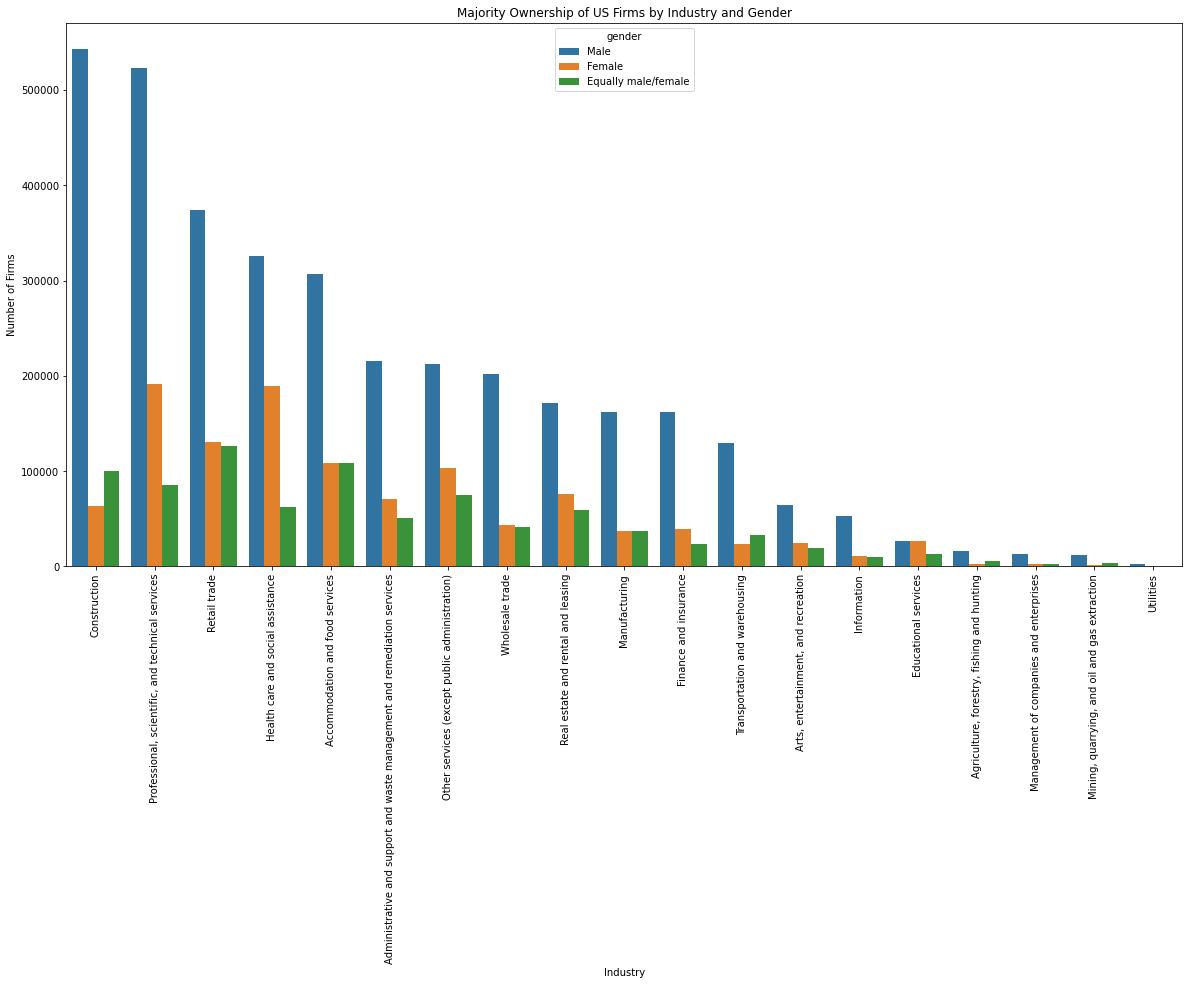

In [17]:
plt.figure(figsize=(20, 10))

ax = sns.barplot(data = workingDF, x = 'industry', y = 'firmpdemp', hue = 'gender')
ax.set(xlabel ="Industry", ylabel = "Number of Firms", title ='Majority Ownership of US Firms by Industry and Gender')
plt.xticks(rotation = 90);
#Education Services has the highest female ownership:male ownership ratio, followed by health care and social services
#The most male-dominated industry tracked is construction
#The industry with the greatest occurrence of equal male/female ownership was in retail trade
#US population is ~50.5% female

In [18]:
#Investigate construction gender disparity by state
#Do a lambda to calculate ratio of male:female 

In [19]:
workingDF2 = df_collection[0]
workingDF2 = workingDF2[workingDF2['firmpdemp'] != 0]
workingDF2 = workingDF2[workingDF2['yibszfi_label'] == 'All firms']
workingDF2 = workingDF2[workingDF2['gender'] == 'Total']

workingDF2 = workingDF2[workingDF2['industry'] != 'Industries not classified']

workingDF2.drop(['geo_id', 'name', 'industry_code', 'gender', 'yibszfi_label'], axis = 1, inplace = True)
workingDF2 = workingDF2.query('race_group_label not in ("Total", "Nonminority", "Minority", "Equally minority/nonminority")')
workingDF2 = workingDF2[workingDF2['industry'] != 'Total for all sectors']

In [20]:
workingDF2 = workingDF2.sort_values(by = 'firmpdemp', ascending = False)

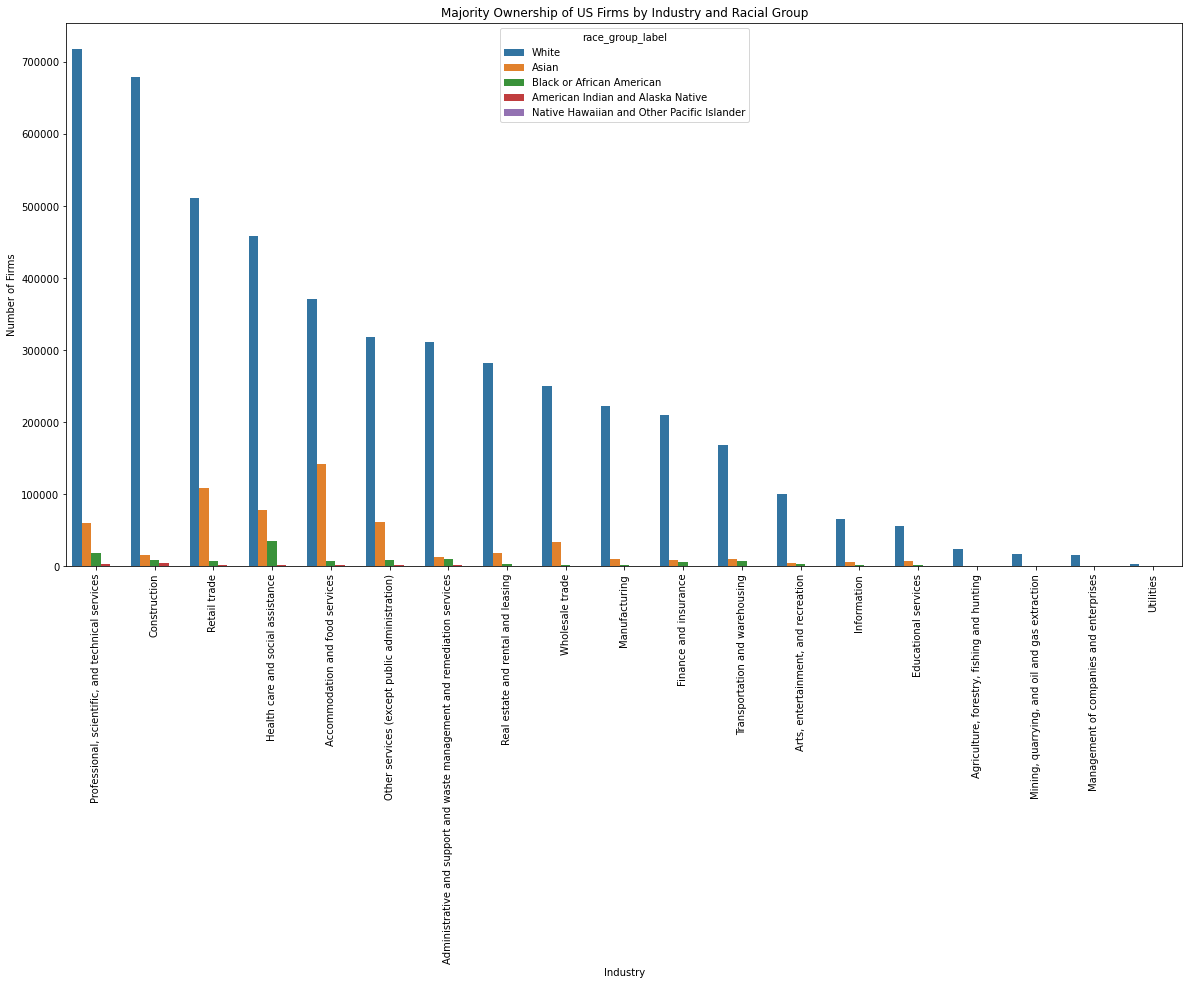

In [21]:
plt.figure(figsize=(20, 10))

ax2 = sns.barplot(data = workingDF2, x = 'industry', y = 'firmpdemp', hue = 'race_group_label')
ax2.set(xlabel ="Industry", ylabel = "Number of Firms", title ='Majority Ownership of US Firms by Industry and Racial Group')
plt.xticks(rotation = 90);

Note that for this breakdown, whether the respondents identify as hispanic is not considered (the census categorizes being hispanic as an ethnic category rather than a racial one.) People that identify as hispanic would also made a selection for their race.
In 2020 the racial breakdown of the US is as follows

White 61.6%

Black or African American 12.4%

Two or more races 10.2%

Some other race 8.4%

Asian 6.0%

Native Americans and Alaska Natives 1.1%

Native Hawaiians and Other Pacific Islanders 0.2%

Data is gathered from https://www.census.gov/library/visualizations/interactive/race-and-ethnicity-in-the-united-state-2010-and-2020-census.html


In [35]:
workingDF3 = df_collection[0]
workingDF3 = workingDF3[workingDF3['firmpdemp'] != 0]
workingDF3 = workingDF3[workingDF3['yibszfi_label'] == 'All firms']
workingDF3 = workingDF3[workingDF3['gender'] == 'Total']

workingDF3 = workingDF3[workingDF3['industry'] != 'Industries not classified']

workingDF3.drop(['geo_id', 'name', 'industry_code', 'gender', 'yibszfi_label'], axis = 1, inplace = True)
workingDF3 = workingDF3.query('race_group_label  in ("Nonminority", "Minority", "Equally minority/nonminority")')
workingDF3 = workingDF3[workingDF3['industry'] != 'Total for all sectors']

workingDF3 = workingDF3.sort_values(by = 'firmpdemp', ascending = False)

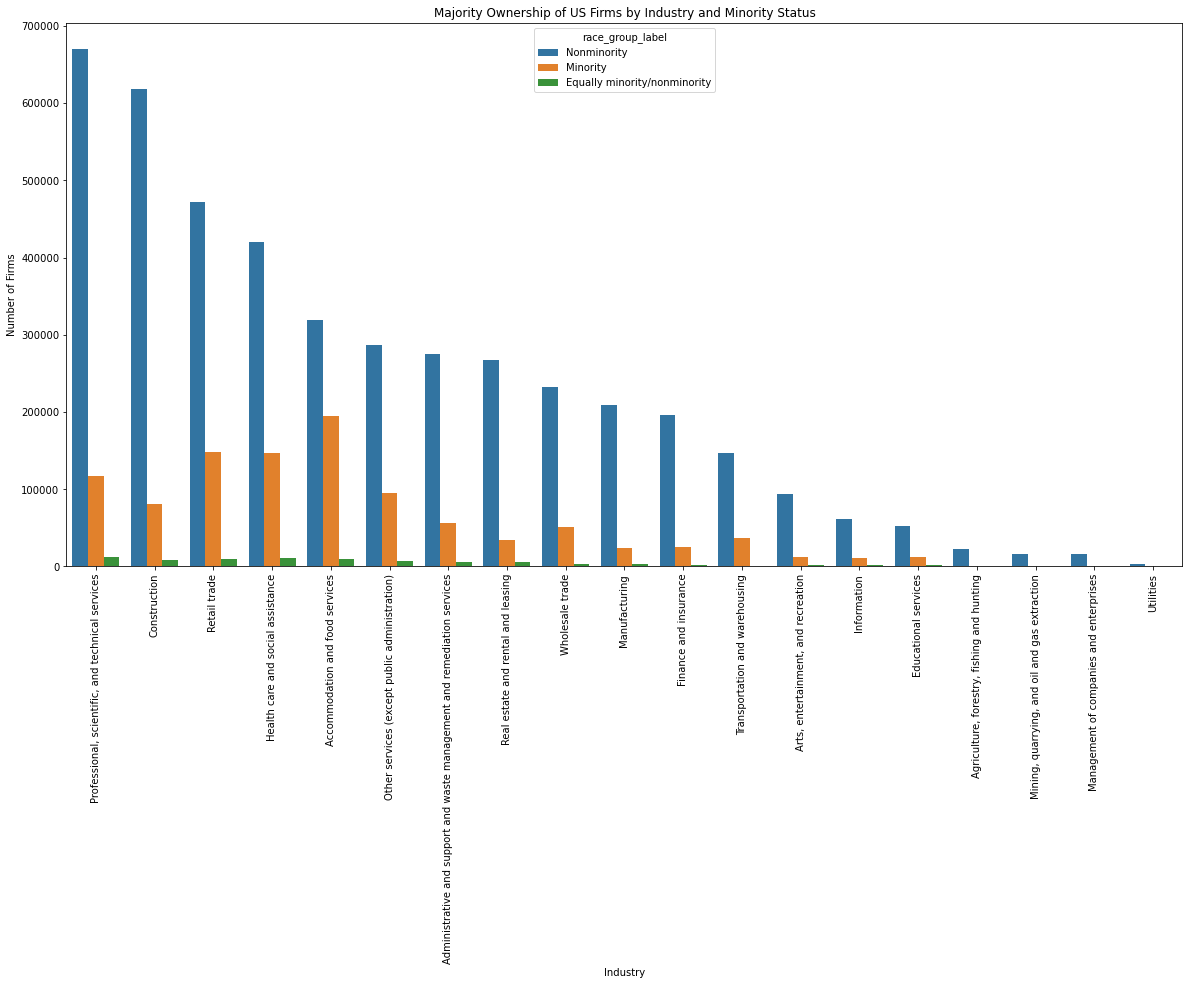

In [36]:
plt.figure(figsize=(20, 10))

ax3 = sns.barplot(data = workingDF3, x = 'industry', y = 'firmpdemp', hue = 'race_group_label')
ax3.set(xlabel ="Industry", ylabel = "Number of Firms", title ='Majority Ownership of US Firms by Industry and Minority Status')
plt.xticks(rotation = 90);

In [37]:
workingDF3 = workingDF3[workingDF3['industry'] == 'Accommodation and food services']

In [38]:
workingDF3

,industry,race_group_label,firmpdemp
4082,Accommodation and food services,Nonminority,319257
4225,Accommodation and food services,Minority,194819
4267,Accommodation and food services,Equally minority/nonminority,9468


Accommodation and food services is (319,257 / 514,076) = 62.1% Nonminority owned, which nearly matches the 61.6% of the US population that is white. However, this was the industry with the highest proportion of minority to nonminority ownership, implying minorities are underrepresented in all other tracked industries.